In [37]:
import torch
import pyro
from pyro.distributions import *
from collections import Counter
import pyro.infer
import pyro.optim
pyro.enable_validation(True)
import matplotlib.pyplot as plt
import tqdm

In [39]:
#nchords = 10
npcs = 4*7+1 # around C: Cbb to C## on LoF

#@pyro.infer.config_enumerate
def chord_model(npcs, nharmonies, nchords, pobserve=0.5):
    # parameters priors:
    # distribution of the harmonies
    p_harmony = pyro.sample('p_harmony', Dirichlet(0.5 * torch.ones(nharmonies)))
    # distribution of ornament probability
    p_is_chordtone = pyro.sample('p_is_chordtone', Beta(1, 1))
    # distribution of notes in the harmonies
    with pyro.plate('harmonies', nharmonies):
        p_chordtones = pyro.sample('p_chordtones', Dirichlet(0.5 * torch.ones(npcs)))
        p_ornaments  = pyro.sample('p_ornaments', Dirichlet(0.5 * torch.ones(npcs)))
        p_ct = p_is_chordtone       * p_chordtones
        p_or = (1 - p_is_chordtone) * p_ornaments
        p_unobserved = p_ct + p_or
        p_tones = torch.cat([pobserve * p_ct, pobserve * p_or, (1-pobserve) * p_unobserved], dim=1)
    # distribution of note rate in chords
    rate_notes = pyro.sample('rate_notes', Gamma(3,1))
    
    # sampling the data:
    chords = list()
    for c in pyro.plate('data', nchords):
        # pick a harmony
        h = pyro.sample('h_{}'.format(c), Categorical(p_harmony))
        # pick a number of notes
        nnotes = 1 + int(pyro.sample('n_{}'.format(c), Poisson(rate_notes)))
        # collect the notes
        #notes = torch.zeros((npcs, 3))
        # determine number of observed vs unobserved notes
#         nobserved = int(pyro.sample('nobs_{}'.format(c), Binomial(nnotes, pobserve)))
#         nunobserved = nnotes - nobserved
#         # determine number of observed chordtones vs observed ornaments
#         nchordtones = int(pyro.sample('nct_{}'.format(c), Binomial(nobserved, p_is_chordtone)))
#         nornaments = nobserved - nchordtones
#         print("nchordtones = ", nchordtones)
#         print("nornaments  = ", nornaments)
#         print("nunobserved = ", nunobserved)
        # sample chordtones
        chordtones = pyro.sample('chord_{}'.format(c), Multinomial(nnotes, p_tones[h]))
#         for i in pyro.plate('notes_{}'.format(c), nnotes):
#             # pick a note type
#             t = pyro.sample('t_{}_{}'.format(c,i), Bernoulli(p_is_chordtone))
#             # pick a pitch from the distribution corresponding to the note type
#             ps = p_chordtones if t.item() == 1. else p_ornaments
#             pitch = pyro.sample('pitch_{}_{}'.format(c,i), Categorical(ps[h]))
#             # decide if the type is observed or not
#             observe_type = pyro.sample('observe_type_{}_{}'.format(c,i), Bernoulli(pobserve))
#             ot = int(t.item()) if observe_type.item() == 1. else 2
#             # add pitch and type to chord
#             notes[pitch.item(), ot] += 1
        # observe the chord
        #counts = pyro.deterministic('chord_{}'.format(c), notes)
        chords.append({'h': h, 'n': nnotes,
                       'counts': chordtones.reshape((npcs,3))})
    return chords

In [40]:
tr = pyro.poutine.trace(chord_model).get_trace(npcs,3,5)
for (name, val) in tr.nodes.items():
    print(name)

_INPUT
p_harmony
p_is_chordtone
harmonies
p_chordtones
p_ornaments
rate_notes
data
h_0
n_0
chord_0
h_1
n_1
chord_1
h_2
n_2
chord_2
h_3
n_3
chord_3
h_4
n_4
chord_4
_RETURN


In [41]:
def chord_guide(npcs, nharmonies, nchords, pobserve=0.5):
    # posterior of p_harmony
    params_p_harmony = pyro.param('params_p_harmony', 0.5 * torch.ones(nharmonies),
                                  constraint=constraints.positive)
    pyro.sample('p_harmony', Dirichlet(params_p_harmony))
    # posteriors of notes dists in harmonies
    with pyro.plate('harmonies', nharmonies):
        params_p_chordtones = pyro.param('params_p_chordtones', 0.5 * torch.ones(npcs),
                                         constraint=constraints.positive)
        pyro.sample('p_chordtones', Dirichlet(params_p_chordtones))
        params_p_ornaments = pyro.param('params_p_ornaments', 0.5 * torch.ones(npcs),
                                         constraint=constraints.positive)
        pyro.sample('p_ornaments', Dirichlet(params_p_ornaments))
    # posterior of note rate
    alpha_rate_notes = pyro.param('alpha_rate_notes', torch.tensor(3.),
                                  constraint=constraints.positive)
    beta_rate_notes = pyro.param('beta_rate_notes', torch.tensor(1.),
                                 constraint=constraints.positive)
    rate_notes = pyro.sample('rate_notes', Gamma(alpha_rate_notes, beta_rate_notes))
    # posterior of ornament probability
    alpha_p_ict = pyro.param('alpha_p_ict', torch.tensor(1.), constraint=constraints.positive)
    beta_p_ict = pyro.param('beta_p_ict', torch.tensor(1.), constraint=constraints.positive)
    pyro.sample('p_is_chordtone', Beta(alpha_p_ict, beta_p_ict))
    # data points
#     for c in pyro.plate('data', nchords):
#         # posterior of chosen harmony
#         params_h = pyro.param('params_h_{}'.format(c), torch.ones(nharmonies)/nharmonies,
#                               constraint=constraints.simplex)
#         pyro.sample('h_{}'.format(c), Categorical(params_h))
#         # the number of notes is usually observed, but it doesn't need to be
#         params_nnotes = pyro.param('params_n_{}'.format(c), torch.tensor(3.))
#         nnotes = int(pyro.sample('n_{}'.format(c), Poisson(rate_notes))) + 1
#         # posterior of chord-tones (also usually observed)
#         params_tones = pyro.param('params_tones_{}'.format(c), torch.ones(3*npcs))
#         chord_tones = pyro.sample('chord_{}'.format(c), Multinomial(nnotes, params_tones))
#         for i in pyro.plate('notes_{}'.format(c), nnotes):
#             # posterior of each note type
#             p_t = pyro.param('p_t_{}_{}'.format(c,i), torch.tensor(0.5), constraint=constraints.simplex)
#             pyro.sample('t_{}_{}'.format(c,i), Bernoulli(p_t))
#             # posterior of each pitch
#             params_pitch = pyro.param('params_pitch_{}_{}'.format(c,i), torch.ones(npcs), constraint=constraints.simplex)
#             pitch = pyro.sample('pitch_{}_{}'.format(c,i), Categorical(params_pitch))
#             # posterior of each observation coin
#             p_obs = pyro.param('p_obs_{}_{}'.format(c,i), torch.tensor(0.5), constraint=constraints.simplex)
#             pyro.sample('observe_type_{}_{}'.format(c,i), Bernoulli(p_obs))

In [42]:
pyro.clear_param_store()
chord_guide(npcs, 3, 5)

In [43]:
chord_model(npcs, 3, 5)

[{'h': tensor(0),
  'n': 2,
  'counts': tensor([[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [2., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]])},
 {'h': tensor(2),
  'n': 1,
  'counts': tensor([[0., 0., 0.],
          [0., 0., 1.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
         

In [44]:
def chord_tensor(notes):
    notetype = {'chordtone': 0, 'ornament': 1, 'unknown': 2}
    chord = torch.zeros((npcs, 3))
    for (pitch, t) in notes:
        chord[pitch%npcs, notetype[t]] += 1
    return chord

def annot_data_obs(chords):
    obs = {}
    for (i, chord) in enumerate(chords):
        obs["h_{}".format(i)] = torch.tensor(chord["label"])
        obs["n_{}".format(i)] = torch.tensor(len(chord["notes"]) - 1.)
        obs["chord_{}".format(i)] = chord_tensor(chord["notes"]).flatten()
    return obs

In [45]:
example_chords = [
    {'label': 0, 'notes': [(0,'chordtone'), (4,'chordtone'), (1,'chordtone'), (4,'ornament')]},
    {'label': 1, 'notes': [(0,'chordtone'), (-3,'chordtone'), (1,'chordtone'), (-2,'unknown')]}
]
example_obs = annot_data_obs(example_chords)
example_obs

{'h_0': tensor(0),
 'n_0': tensor(3.),
 'chord_0': tensor([1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'h_1': tensor(1),
 'n_1': tensor(3.),
 'chord_1': tensor([1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.])}

In [46]:
conditioned_model = pyro.condition(chord_model, data=example_obs)

In [47]:
conditioned_guide = pyro.condition(chord_guide, data=example_obs)

100%|██████████| 5000/5000 [00:52<00:00, 95.13it/s]


Text(0, 0.5, 'loss')

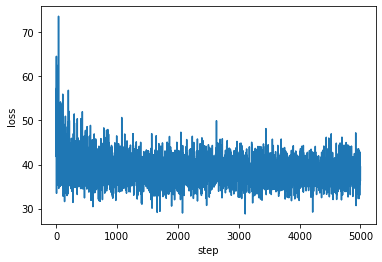

In [50]:
# inference
pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_model,
                     guide=chord_guide,
                     optim=pyro.optim.Adam({"lr": 0.005, "betas": (0.95, 0.999)}),
                     loss=pyro.infer.TraceEnum_ELBO())

losses = []
nsteps = 5000
for i in tqdm.trange(nsteps):
    #st = pyro.get_param_store()
    #print(st.match(".*rate_notes"))
    #try:
    losses.append(svi.step(npcs, 3, 2))
    #except:
    #    for item in pyro.get_param_store().items():
    #        print(item)
    #    break

plt.plot(losses)
plt.xlabel("step")
plt.ylabel("loss")

In [121]:
torch.log(torch.tensor(0.))

tensor(-inf)

In [160]:
Multinomial(1, torch.ones((3,2))).sample()

AttributeError: 'Tensor' object has no attribute 'to_event'

?torch.cat

In [161]:
? torch.cat